## Estimating Causal Impacts with CausalPy from PyMC Labs

Lionel Messi, the newest member of Major League Soccer (MLS) Club Inter Miami, was unveiled on July 15. Through the 2025 Major League Soccer season, the greatest soccer player in history will be a member of the Miami team.
An important development for Apple's streaming service is Messi's presence in Miami. Apple revealed their MLS season pass, which allows customers to watch every match in the league. Tim Cook, the CEO of Apple, stated during a recent earnings call that[Messi has helped increase Apple TV+ subscribers](https://www.businessinsider.com/apple-tv-mls-lionel-messi-tim-cook-mls-soccer-sports-2023-8).

Although AppleTV may not have dominated the streaming market in Argentina in comparison to other streaming services like Netflix or Amazon Prime, Apple's alliance with the Major League Soccer (MLS) may change this.
Therefore, is Messi's signing with the Major League Soccer (MLS) going to significantly alter the streaming landscape in Argentina? We may examine the last 90 days of Google Trend data to determine the popularity of the main streaming services in Argentina in order to respond to this query.
Our ultimate goal is to calculate the causal effect that Messi's arrival to the Major League Soccer (MLS) has on Argentine streaming platform preferences.


Now imagine you were a Data Scientist working at Apple and you were given the task of estimating this causal question, how would you approach it?
Well, it is not new to any data scientist that *randomized control trial* (RCT) — also referred to as *online experiments* or *A/B tests* — are the standard rule in the industry to estimate causal effects. In an RCT a random group is exposed to the treatment while the other group stays as the control group, this ensures that any observed difference between the two groups can be due only to the treatment and no other unobserved variable, thus eliminating selection bias.

In RCTs, we have full control over the treatment assignment mechanism. However, many times RCTs are not feasible for being expensive to run, unethical, etc. In such cases, Quasi-experimental Designs come to the rescue, especially when we don't have control over the treatment assignment mechanism. 

In [1]:
import arviz as az
import causalpy as cp
import matplotlib.pyplot as plt
import pandas as pd
import pymc as pm
import seaborn as sns
import numpy as np
from joblib import Parallel, delayed

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [16, 8]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

seed = 42

# The Data

We will use Google Trend data of the last 90 days for our analysis.
*Apple TV+* will be our treated platform, while the platforms chosen as controls include *Disney+*, *Paramount+*, *Netflix*, *Hulu*, *HBO*, *YoutubeTV* and *Peacock*.
Our intervention day will be the 15th of July of 2023, the date on which Messi joined the MLS League.

Now lets read the data and plot these time series:

In [2]:
df = (
    pd.read_csv("Datasets/google_trends_data.csv", parse_dates=["index"])
    .set_index("index")
)

In [26]:
df

,Disney,Paramount,AppleTV,Netflix,hulu,HBO,YoutubeTV,PrimeVideo,Peacock
index,,,,,,,,,
2023-05-26,69,81,3,86,21,85,0,67,0
2023-05-27,73,82,3,90,38,87,83,69,29
2023-05-28,76,100,2,91,0,100,0,70,0
2023-05-29,51,52,1,53,52,56,0,41,64
2023-05-30,48,54,2,47,39,41,0,33,0
...,...,...,...,...,...,...,...,...,...
2023-08-05,71,60,5,77,33,65,0,70,0
2023-08-06,74,73,21,84,28,83,0,82,37
2023-08-07,50,48,36,44,0,44,47,45,45


In [3]:
control_platforms = [
    "Disney",
    "Paramount",
    "Netflix",
    "hulu",
    "HBO",
    "YoutubeTV",
    "Peacock",
]
target_platform = "AppleTV"
treatment_index = pd.to_datetime("2023-07-15")

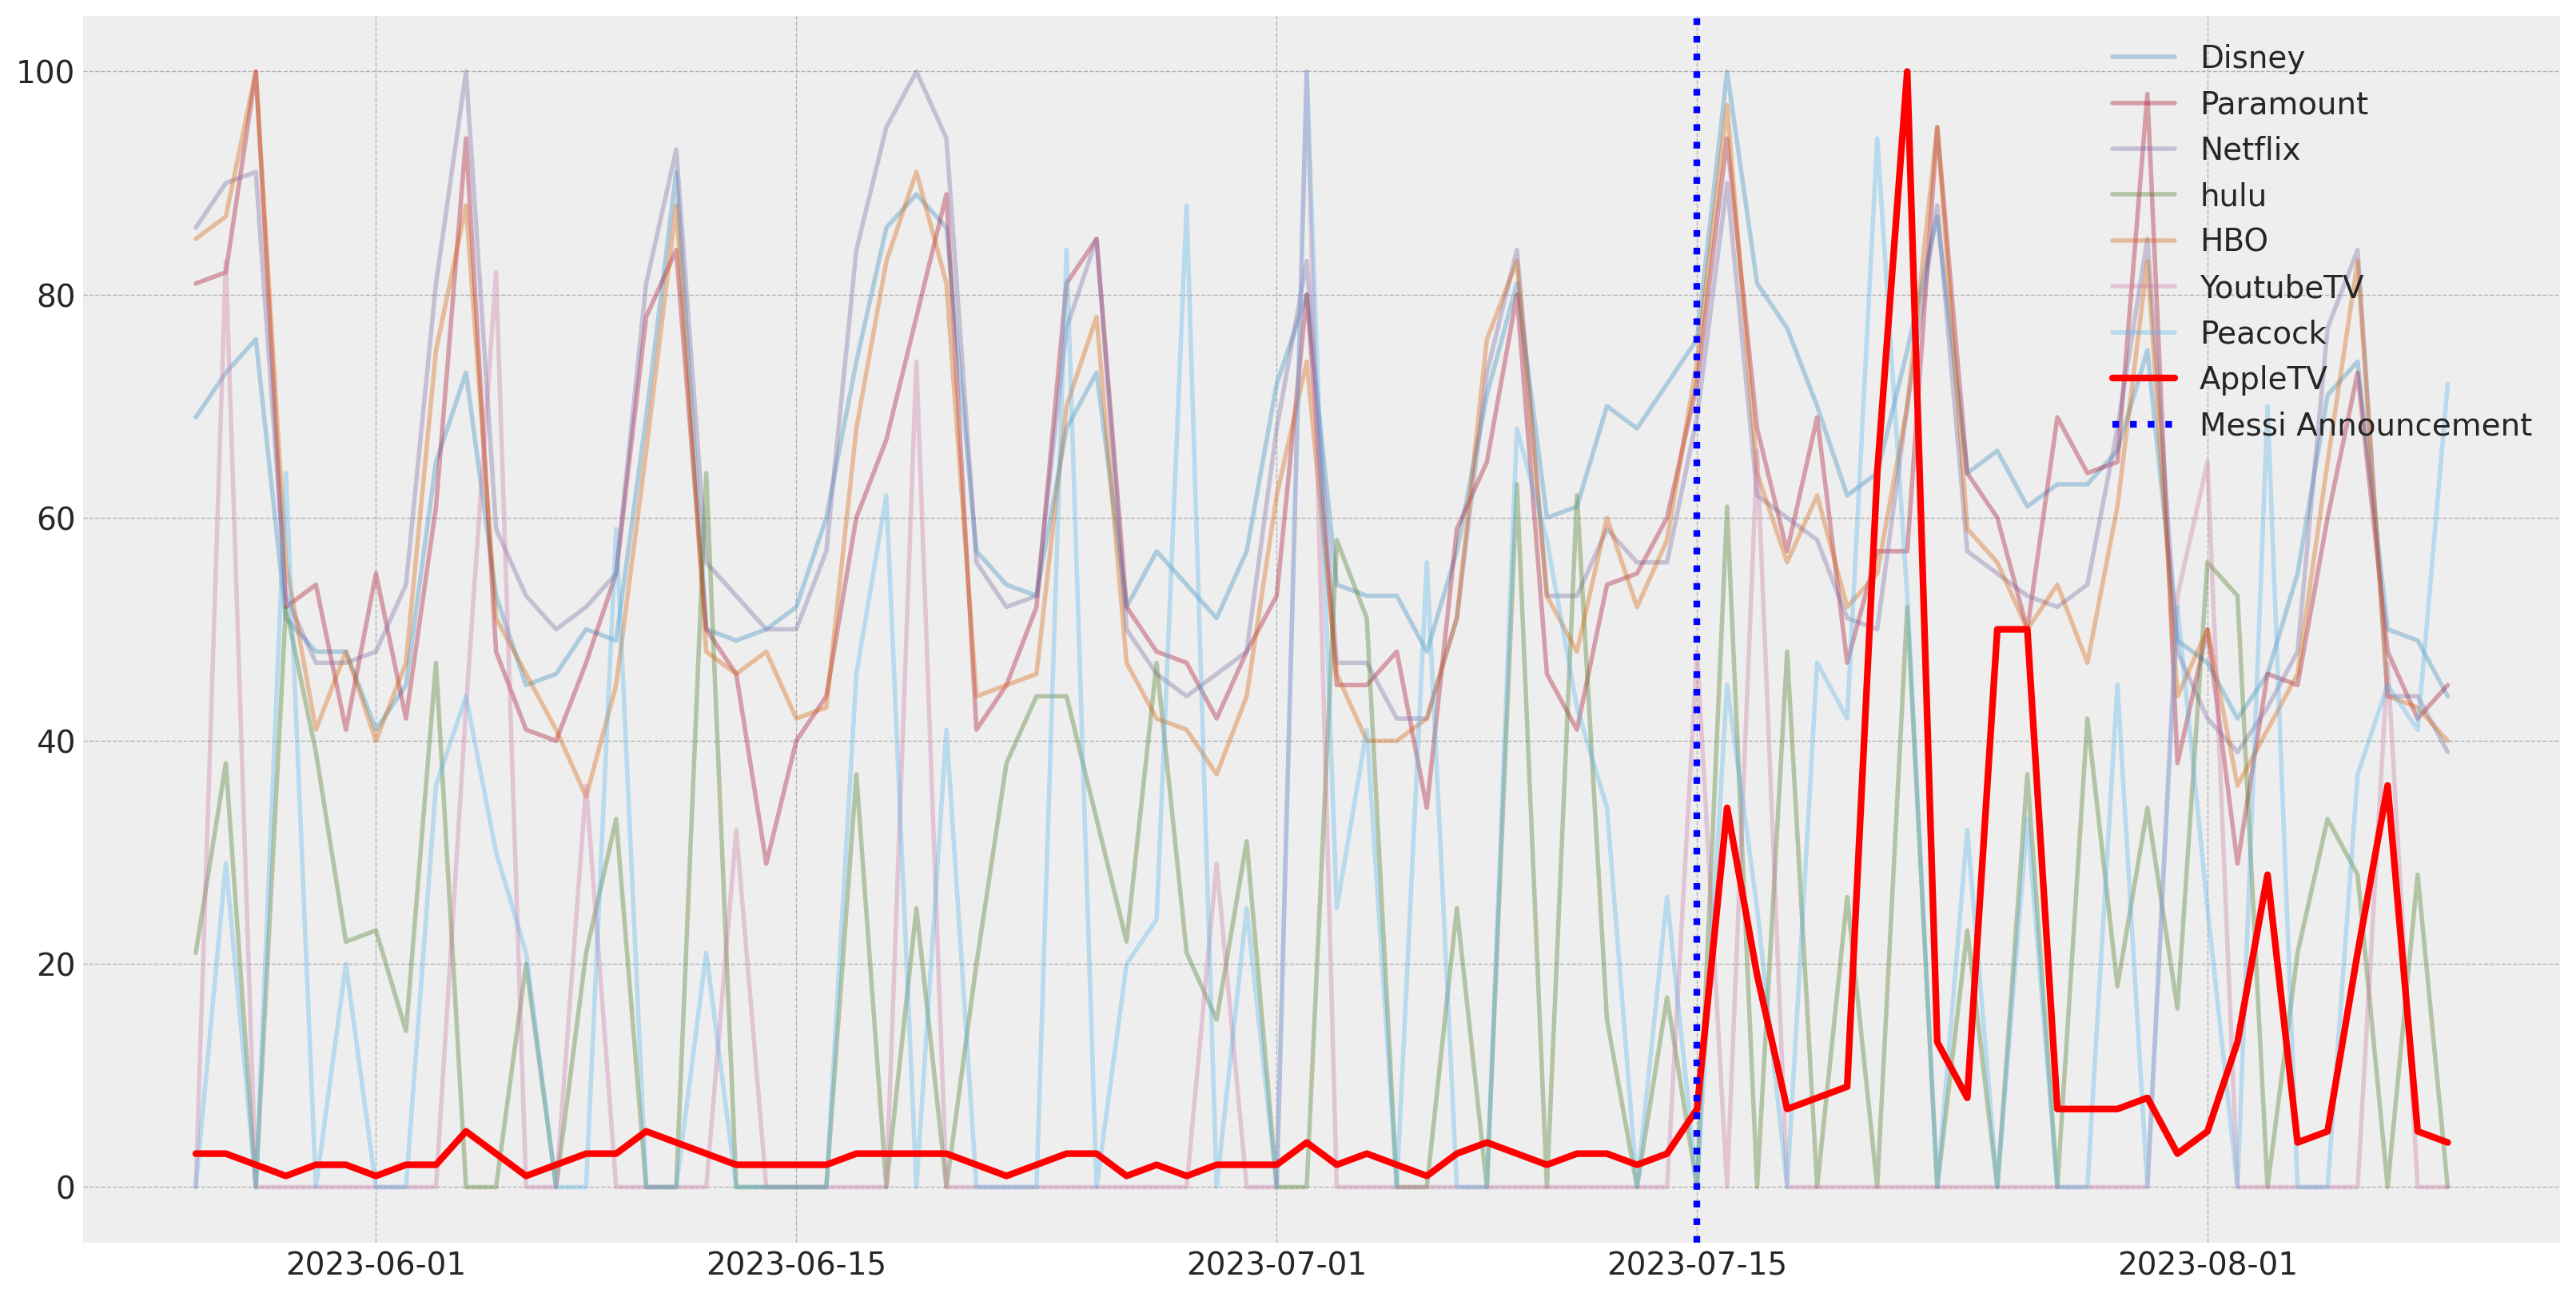

In [4]:
fig, ax = plt.subplots()
for col in control_platforms:
    ax.plot(df.index, df[col], alpha=0.35, label=col)

ax.plot(df.index, df[target_platform], color="red", lw=3, label=target_platform)
ax.axvline(x=treatment_index, color="b", ls=":", lw=3, label="Messi Announcement")
ax.legend(loc="upper right");

Upon initial examination, we observe that *AppleTV* Google views sharply rise following the intervention. Nevertheless, the *AppleTV* time series is difficult to comprehend due to its high degree of variability. 
Furthermore, it is unclear if the donor characteristics will continue to follow their previous trends after therapy.
Due to these complications, it is challenging to pinpoint the Messi Announcement as the cause of the *AppleTV* change, and it is even more challenging to measure this causal effect.

How can we estimate the causal impact of google views without having the control group?

The Answer is we could implement Synthetic Controls in order to get a clear estimate of the causal impact?

# Deep Dive into Synthetic Controls

We are trying to estimate what would have happened, in terms of Google trends, if the intervention had not taken place. This is a counterfactual question, since we want to compare the actual Google trends of *AppleTV* vs what would have been if Messi hadn't joined the MLS.
Although we can't oberserve the counterfactual (which has been named as the [Fundamental Problem of Causal Inference](https://en.wikipedia.org/wiki/Rubin_causal_model#:~:text=The%20Fundamental%20Problem%20of%20Causal%20Inference%20is%20that%20it%20is,to%20estimate%20the%20missing%20counterfactuals)), there are many quasi-experimental methods that can help us to estimate this.
Here, we will use the Synthetic Control estimator to estimate the counterfactual after the intervention period.
As we saw earlier, we have *AppleTV* that is our treated unit, and we have a couple of other control units, often referred to as the *donor pool*. With that said, lets dive deeper into Synthetic Control.

If you are interested in a more intuitive explanation of this checkout [Chapter 15 of Matheus Facure online book.](https://matheusfacure.github.io/python-causality-handbook/15-Synthetic-Control.html#don-t-extrapolate)

### A Bayesian Approach

Since we will be using the PyMC library, which is a python package for constructing Bayesian models, lets introduce what we need to know in order to approach Synthetic Coltrol using Bayesian statistics.

Bayesian analysis is based on Bayes' theorem, and it essentially combines our prior beliefs about an event with new evidence to give us an updated belief. At each step, rather than starting from scratch, it builds upon previous knowledge to adapt to the latest information. Think of Bayesian statistics as a feedback loop: you start with a belief (prior), gather new evidence (data), and update your belief (posterior). If you get more data later on, the current posterior can then become the new prior, and the process continues.

Soon, we'll be implementing a model using PyMC. However, if you are interested in using the CausalPy library with more traditional Ordinary Least Squares estimation methods via scikit-learn models
[checkout this example](https://causalpy.readthedocs.io/en/latest/notebooks/sc_skl.html).

### In Summary

- **Before the intervention**: we will find the weights that better predict *AppleTV* using the donor pool (*Netflix*, *Amazon Prime*, etc.). 
- **After the intervention**: we will use these weights to predict the synthetic control. In other words, we use the weights and the donor pool to estimate the counterfactual of *AppleTv*: we would have happened if Messi hadn't joined the MLS.
- The **Treatment Effect** over time will be the difference between the treated unit (*AppleTV*) and the synthetic control.

With all the foundational pieces in place, let's dive into the exciting part: implementing this in code!

# Estimating the Causal Impact

In order to run the analysis, we will define the model formula:

In [5]:
formula = target_platform + " ~ " + "0 + " + " + ".join(control_platforms)

print(formula)

AppleTV ~ 0 + Disney + Paramount + Netflix + hulu + HBO + YoutubeTV + Peacock


Then we’ll use the WeightedSumFitter() class from the *pymc_models* module:

In [6]:
model = cp.pymc_models.WeightedSumFitter(
    sample_kwargs={"target_accept": 0.95, "random_seed": 42}
)

And finally, we fit the model:

In [7]:
results = cp.pymc_experiments.SyntheticControl(
    df,
    treatment_index,
    formula=formula,
    model=model,
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 38 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


### Analyzing model coeffcients

Let’s look at how each of the donor pool predictors contributed to the prediction.
For that we will examine the posterior parameter estimates for each of the beta weightings for each country, along with the estimate of the measurement standard deviation.

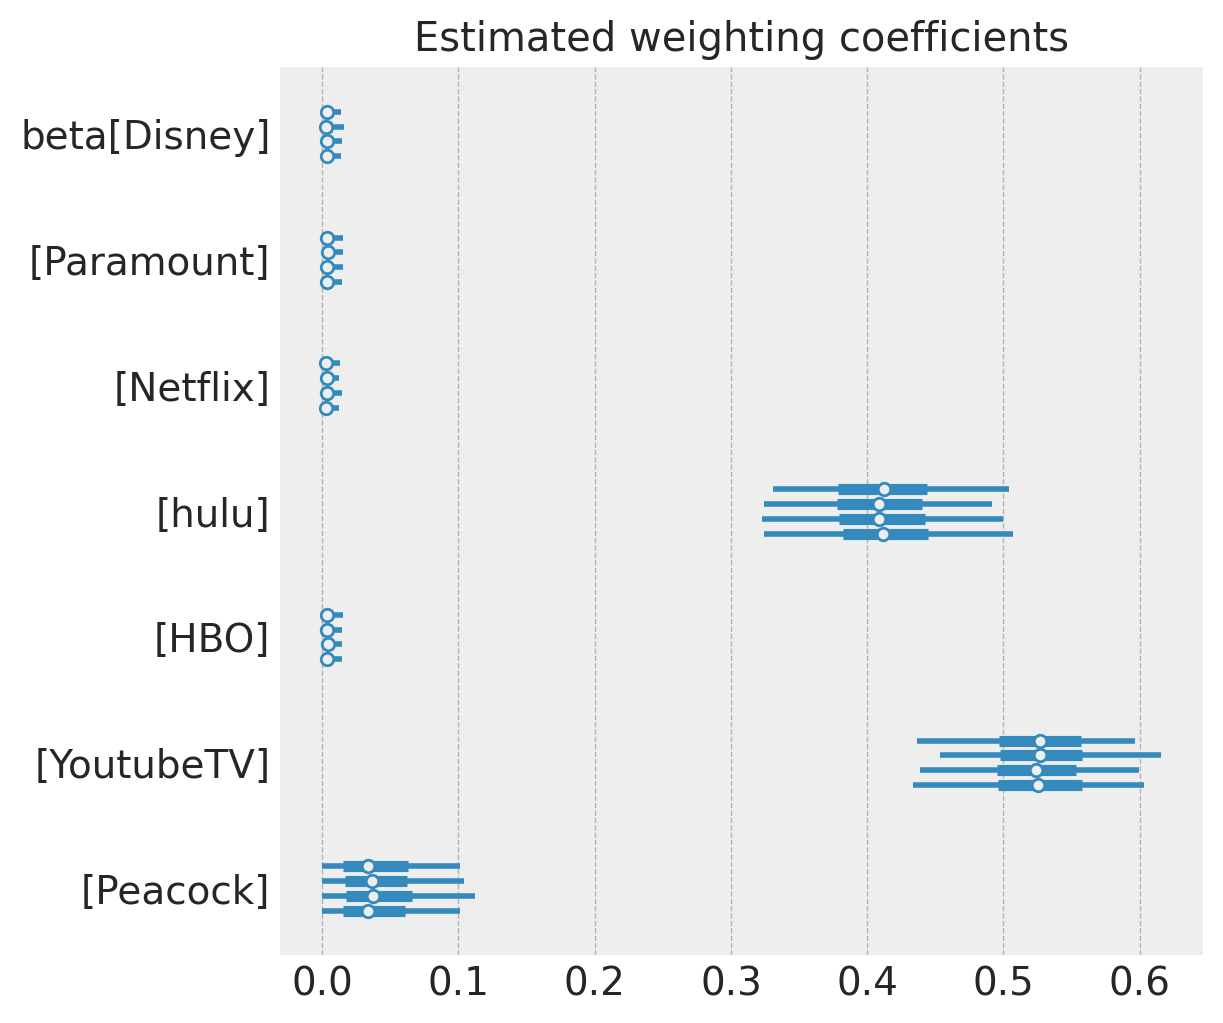

In [8]:
ax = az.plot_forest(results.idata, var_names="beta", figsize=(6, 5))
ax[0].set(title="Estimated weighting coefficients");

We can confirm that the weights satisfy the constraints: they are all positive and add up to one.

Lets take a look at confidence intervals for these estimates:

In [9]:
results.summary()

===============================Synthetic Control================================
Formula: AppleTV ~ 0 + Disney + Paramount + Netflix + hulu + HBO + YoutubeTV + Peacock
Model coefficients:
Disney                        0.01, 94% HDI [0.00, 0.02]
Paramount                     0.01, 94% HDI [0.00, 0.02]
Netflix                       0.00, 94% HDI [0.00, 0.02]
hulu                          0.41, 94% HDI [0.32, 0.50]
HBO                           0.01, 94% HDI [0.00, 0.02]
YoutubeTV                     0.53, 94% HDI [0.44, 0.61]
Peacock                       0.04, 94% HDI [0.00, 0.12]
sigma                         10.93, 94% HDI [10.09, 11.81]


Note that a couple of the 94% highest density intervals (HDIs) contains zero, suggesting that not all predictors were significant. 


Now, lets plot the results.

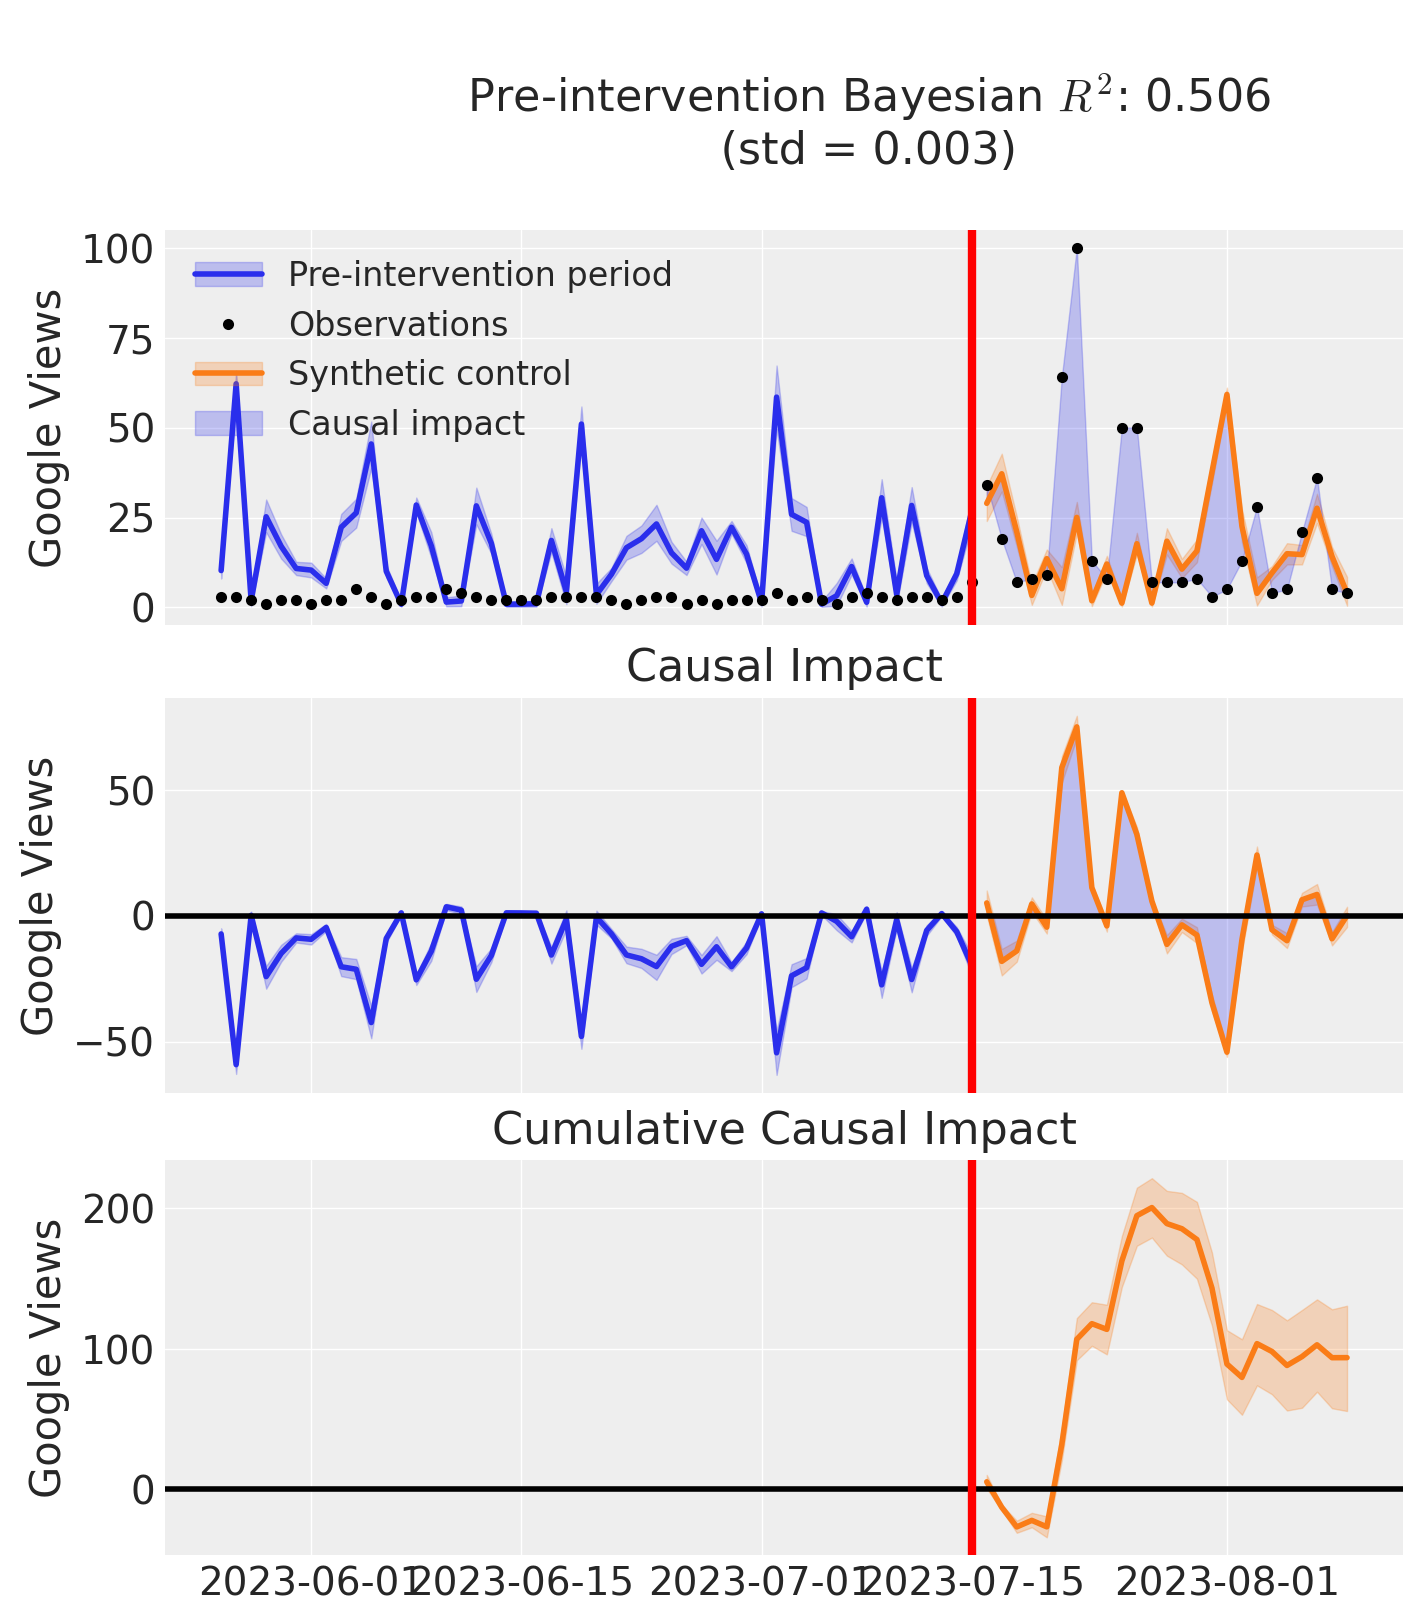

In [10]:
az.style.use("arviz-darkgrid")

fig, ax = results.plot(plot_predictors=False)

for i in [0, 1, 2]:
    ax[i].set(ylabel="Google Views")

plt.show()

From a first glance at the initial graph, there's notable noise, which raises concerns about the synthetic control's ability to construct the treated unit (*AppleTV*) before the intervention. Yet, the Bayesian R^2 value for pre-treatment data is 0.506. Although it isn't perfect, it is a reasonable value.

Now let's examine the causal impact. We can start by plotting the posterior distribution of the cumulative causal impact.

[Text(0.5, 1.0, 'Estimated cumulative causal impact'),
 Text(0.5, 0, 'Google Views')]

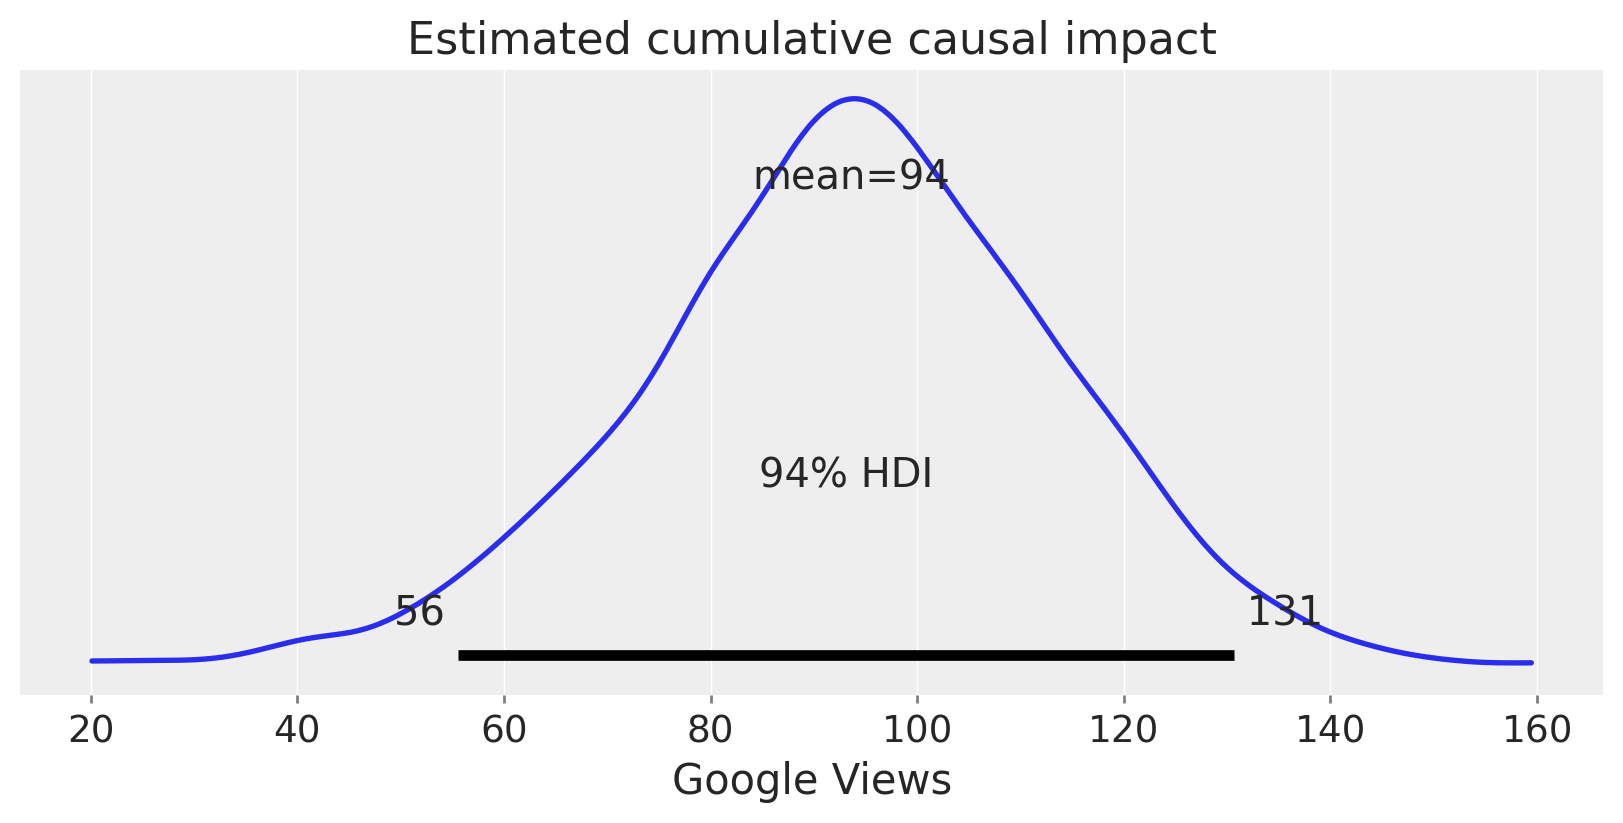

In [11]:
index = results.post_impact_cumulative.obs_ind.max()

last_cumulative_estimate = results.post_impact_cumulative.sel({"obs_ind": index})

ax = az.plot_posterior(last_cumulative_estimate, figsize=(8, 4))
ax.set(
    title="Estimated cumulative causal impact",
    xlabel="Google Views",
)

We can extract the mean and standard deviation of this distribution:

In [12]:
az.summary(last_cumulative_estimate, kind="stats")

,mean,sd,hdi_3%,hdi_97%
x,93.609,19.975,55.533,130.632


Our estimated cumulative causal impact is 93, with a 94% confidence interval ranging from 55 to 130. This means that the intervention – Messi's announcement – resulted in an additional 93 Google views for *AppleTV*, which can be attributed to this specific intervention.

You might be curious about the average daily causal impact during the post-intervention period. We can calculate this the following way:

In [13]:
az.summary(results.post_impact.mean("obs_ind"))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,3.744,0.799,2.221,5.225,0.014,0.01,3126.0,3235.0,1.0


However, it's crucial to approach the mean impact statistic with caution. It's meaningful only when the intervention appears to have a sustained and fairly consistent effect on the outcome.
If the impact is short-lived, then much of the post-intervention period might show the effect diminishing.

Indeed, if we observe the cumulative causal impact graph, it's evident that the effect starts off strong but gradually diminishes over time.

### Choosing the Right Donor Pool

Synthetic controls should only be used in cases when the pre-treatment fit is nearly flawless. The R2 value in our analysis was a bit far from ideal one but in real world problems its okay to consider as baseline because we cannot get the nearly fit donors. How then may we make this better?

The donor pool is one important factor to take into account. A synthetic control estimator's validity is primarily determined by its capacity to follow the course of the outcome variable for the treated unit during the pre-intervention phase.
A lot of professionals would advise employing at least five to twenty-five variables.

However, there is a significant risk of overfitting in scenarios with a short pre-intervention period, a big donor pool, and high levels of noise.
To reduce interpolation biases and the potential of overfitting, it is advised to choose controls units that have trajectories that are comparable to the treated unit during the pre-intervention period.



## How Can We Increase Our Confidence in This Method?

[Abadie, Diamond, and Hainmueller (2010)](https://www.tandfonline.com/doi/abs/10.1198/jasa.2009.ap08746) introduced an approach that incorporates permutation techniques to the synthetic control estimator.

Basically, the effect on the intervention is estimated separately for each of the units in the donor pool.
The permutation distribution is obtained by iteratively reassigning the treatment to the units in the donor pool and estimating “placebo effects” in each iteration.
Then, the permutation distribution is constructed by pooling the effect estimated for the treated unit together with placebo effects estimated for the units in the donor pool.
Once we have the effect for each unit, we check if the treatment effect in *AppleTV* is sufficiently larger when compared to the other fake treatment. 

Let's implement the code for this part. We need to fit the *SyntheticControl()* class as we did above but one time for each streaming platform in our donor pool.
Once again checkout [Chapter 15 of Matheus Facure online book](https://matheusfacure.github.io/python-causality-handbook/15-Synthetic-Control.html#making-inference) for more details on this part.

In [14]:
donor_data = pd.DataFrame(
    {
        "AppleTV": [df.AppleTV.values],
        "Disney": [df.Disney.values],
        "Paramount": [df.Paramount.values],
        "Netflix": [df.Netflix.values],
        "hulu": [df.hulu.values],
        "HBO": [df.HBO.values],
        "YoutubeTV": [df.YoutubeTV.values],
        "Peacock": [df.Peacock.values],
    }
)

all_platforms = control_platforms.copy() ## columns of the donor pool
all_platforms.append(target_platform)

In [51]:
results_dict = {}

In [52]:
def compute_unit_result(treated_unit, donor_data, df, treatment_index, seed):
    donor_data_for_treated = donor_data.drop(columns=[treated_unit])
    treatment_data = donor_data[[treated_unit]]

    formula = f"{treated_unit} ~ 0 + {' + '.join(donor_data_for_treated.columns)}"
    model = cp.pymc_models.WeightedSumFitter(
        sample_kwargs={"target_accept": 0.95, "random_seed": seed}
    )
    results = cp.pymc_experiments.SyntheticControl(
        df, treatment_index, formula=formula, model=model
    )

    pre_mean = results.pre_impact.mean(dim=["chain", "draw"]).values
    post_mean = results.post_impact.mean(dim=["chain", "draw"]).values


    #results_dict[treated_unit].append(pre_mean)
    #results_dict[treated_unit].append(post_mean)

    return pre_mean, post_mean


    #return {"treated_unit": treated_unit, "pre_mean": pre_mean, "post_mean": post_mean}




In [53]:
all_platforms = donor_data.columns.tolist()
for treated_unit in all_platforms:
    pre_mean, post_mean = compute_unit_result(treated_unit, donor_data, df, treatment_index, seed)

    #add a key-value pair to the empty dictionary
    results_dict[f"{treated_unit}"] = np.concatenate((pre_mean, post_mean), axis=None)

    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 35 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 41 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 34 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 36 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 40 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


In [54]:
results_df = pd.DataFrame(results_dict)

results_df

,AppleTV,Disney,Paramount,Netflix,hulu,HBO,YoutubeTV,Peacock
0,-7.264203,-11.807825,3.032886,8.139462,1.842332,7.451006,-14.434155,-26.803155
1,-59.174096,-12.567523,-0.948421,9.158692,10.820954,4.388878,65.987084,-17.494725
2,0.126406,-11.771993,13.329191,0.847820,-21.173210,14.721010,-14.957054,-21.676877
3,-24.212006,-1.494210,-0.549580,-0.480200,26.649732,5.583942,-13.553274,32.774192
4,-14.996102,2.975136,11.965582,2.396134,27.241085,-4.867936,-9.118944,-25.532578
...,...,...,...,...,...,...,...,...
71,-9.945439,1.016592,-6.312402,10.989338,15.222807,-2.562590,-14.334953,-29.018967
72,6.300308,-5.370115,-4.936683,6.042212,-8.413003,6.974044,-30.537357,3.421567
73,8.412196,6.525195,4.558039,-2.474819,-40.473270,-0.677530,9.616344,17.653598
74,-9.181497,6.477296,-0.300462,-0.810606,6.905780,1.125325,-13.412872,19.237155


After completing this calculation, let's visualize these time series on a plot.

AppleTV


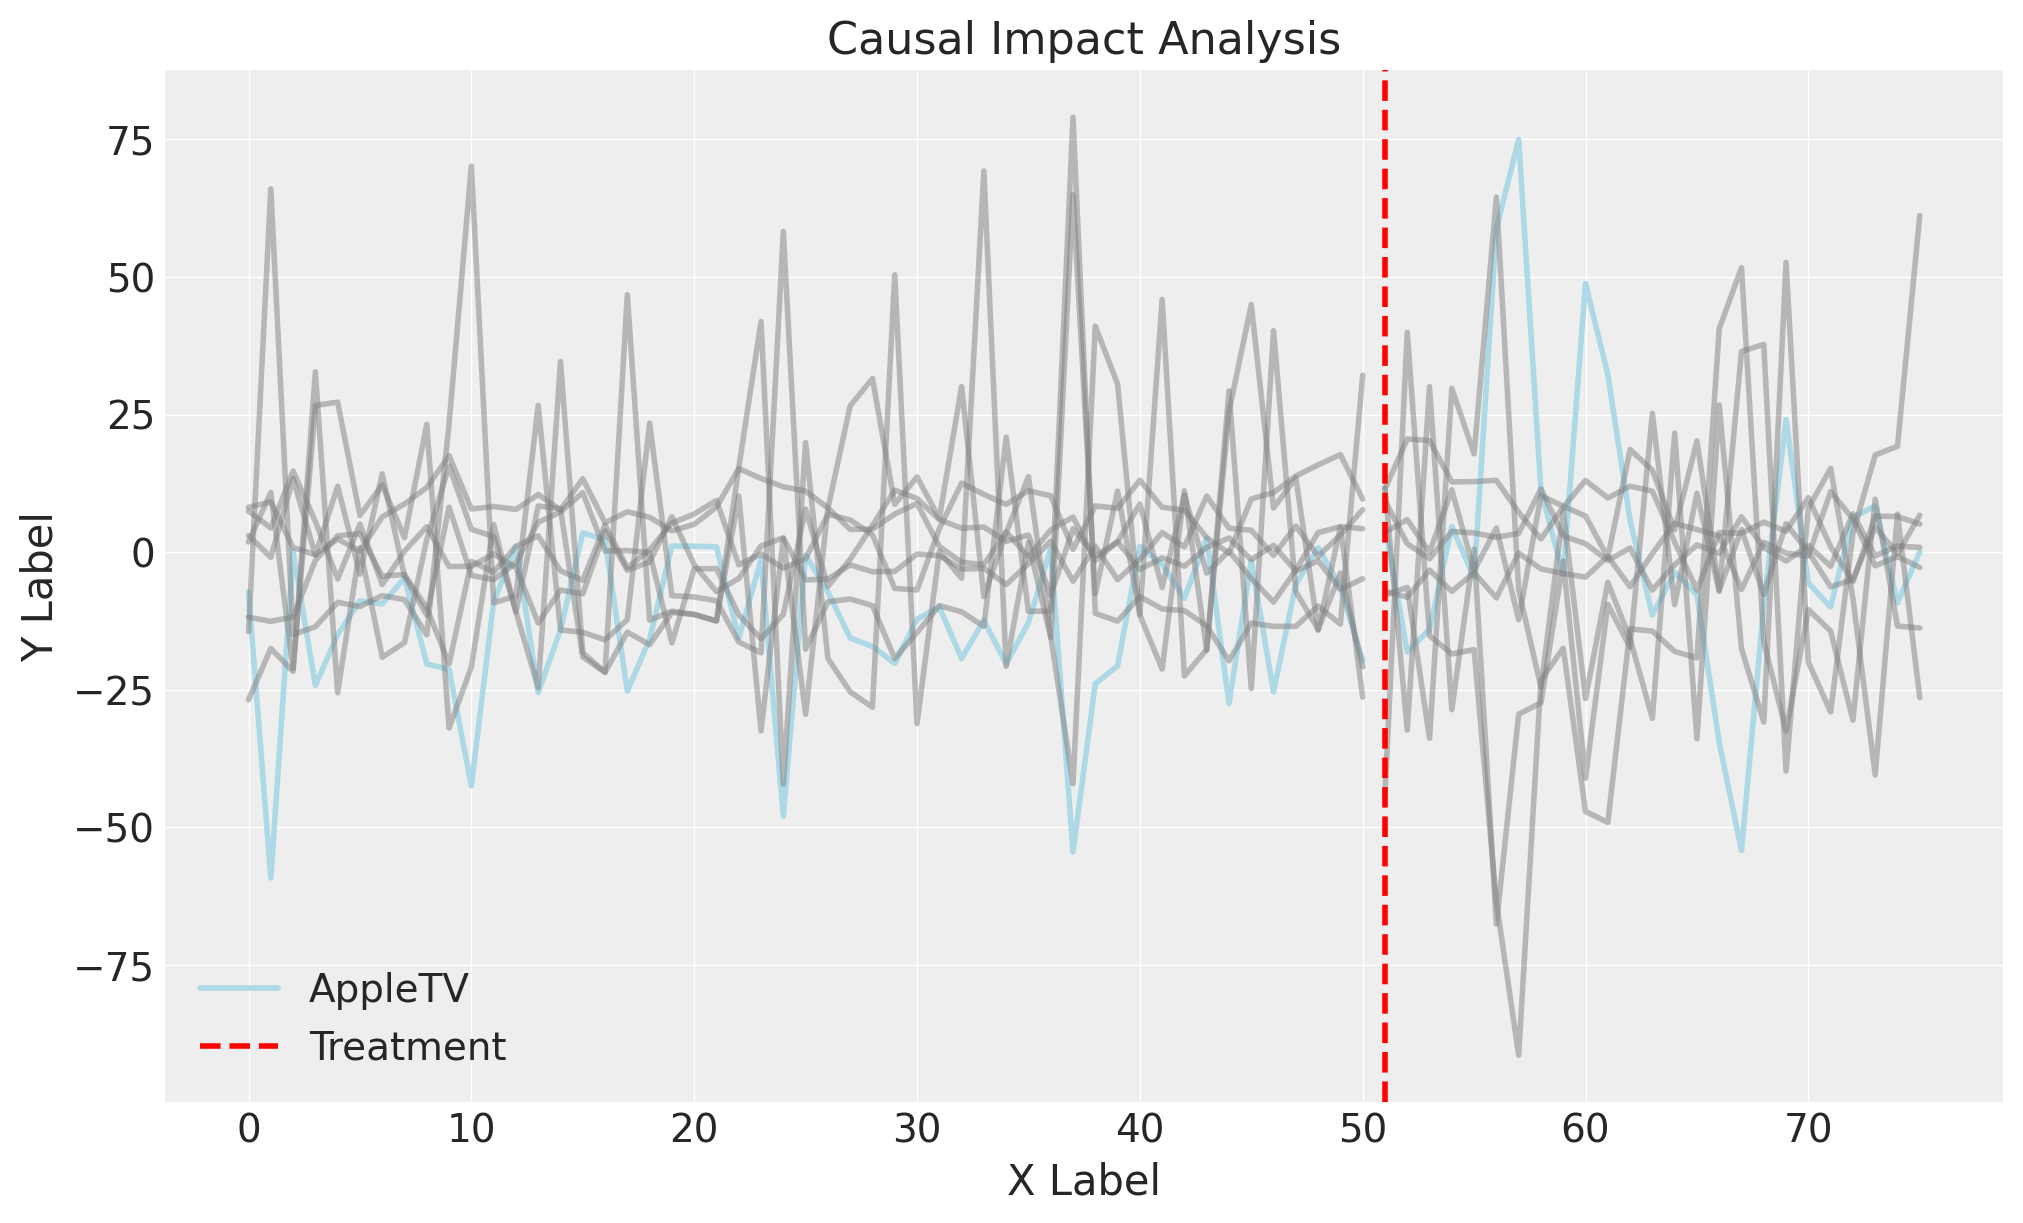

In [66]:
fig, ax = plt.subplots(figsize=(10, 6))
for col in results_df.columns:

    if col == "AppleTV":
        print(col)
        ax.plot(
            results_df.loc[:50].index,
            results_df[col].loc[:50],
            color="lightblue",
            label=f"{col}",
        )
        ax.plot(
            results_df.loc[51:].index,
            results_df[col].loc[51:],
            color="lightblue",
        )
    else:
        ax.plot(
             results_df.loc[:50].index,
            results_df[col].loc[:50],
            color="grey",
            alpha=0.5,
        )
        ax.plot(
            results_df.loc[51:].index,
            results_df[col].loc[51:],
            color="grey",
            alpha=0.5,
        )
    
    
ax.axvline(x=51, color="red", linestyle="--", label="Treatment")
ax.set_xlabel("X Label")
ax.set_ylabel("Y Label")
ax.set_title("Causal Impact Analysis")
ax.legend()
plt.show()

From the graph, we notice that the effect for *AppleTV* is quite extreme, at least right after the intervention, but it is not so clear.
Lets explore this a little bit more. We'll begin by examining the mean causal effect:

In [93]:
results_mean_effects = pd.DataFrame(results_df.loc[51:].apply(lambda x: sum(x))).reset_index()

results_mean_effects.rename(columns={'index' : 'treated_unit',
                                     0: 'mean_causal_effect'}, inplace=True)

results_mean_effects

,treated_unit,mean_causal_effect
0,AppleTV,93.609095
1,Disney,189.439963
2,Paramount,86.089695
3,Netflix,-39.259951
4,hulu,-203.954114
5,HBO,42.692608
6,YoutubeTV,-442.146609
7,Peacock,33.231689


In [96]:

apple_tv_effect = results_mean_effects['mean_causal_effect'][0]

other_effects = results_mean_effects['mean_causal_effect'][1:].values


We can estimate the P-value as the proportion of times the effect of *AppleTV* is lower than all the other estimated effects.

$
PV=\frac{1}{N}\sum \mathcal{1}\{\hat{\tau}_{AppleTV} < \hat{\tau}_j\}
$

In [97]:
np.mean(np.array(other_effects) > apple_tv_effect)

0.14285714285714285

As we can observe, out of the 8 placebo effects we've estimated only one is higher than the effect we found in *AppleTV*.

We can see that for *Disney* we get a higher causal effect compared to *AppleTv*:

But wait, is *Disney* even a good fit?

Lets add to our analysis the MSE in the **preintervention period**:

$
MSE = \frac{1}{N}\sum\bigg(Y_t - \hat{Y}^{Synth}_t\bigg)^2
$

In [104]:
def pre_treatment_mse(data, treated_unit_column, pre_mean_value):
    pre_treat_error = (data[treated_unit_column].values - pre_mean_value.values) ** 2
    return pre_treat_error.mean()


mse_results = []

for c in results_df.columns:
    mse = pre_treatment_mse(df[df.index <= treatment_index], c, results_df[col].loc[:50])
    mse_results.append(mse)


results_mean_effects["pre_treatment_mse"] = mse_results

# for index, row in results_df.iterrows():
#     treated_unit = row["treated_unit"]
#     pre_mean = row["pre_mean"]

#     mse = pre_treatment_mse(df[df.index <= treatment_index], treated_unit, pre_mean)
#     mse_results.append(mse)

#results_mean_effects["pre_treatment_mse"] = mse_results

In [105]:
results_mean_effects[["treated_unit", "mean_causal_effect", "pre_treatment_mse"]]

,treated_unit,mean_causal_effect,pre_treatment_mse
0,AppleTV,93.609095,683.965346
1,Disney,189.439963,4687.272056
2,Paramount,86.089695,4375.247814
3,Netflix,-39.259951,5068.587945
4,hulu,-203.954114,1532.192371
5,HBO,42.692608,4397.980811
6,YoutubeTV,-442.146609,1394.630385
7,Peacock,33.231689,636.417650


We note that the MSE (during the pre-intervention period) for *Disney* is significantly high, indicating it is a bad fit. One good idea is to remove units with high error.
In fact, [Abadie, Diamond, and Hainmueller (2010)](https://www.tandfonline.com/doi/abs/10.1198/jasa.2009.ap08746) suggests removing units for which the MSE is two times higher than the MSE of the treated unit.
Using this guideline, *AppleTV* stands out as the unit with the highest (or more extreme) value of treatment effect.

## References

[1] M. Facure, [Chapter 15 of Causal Inference for the Brave and True](https://matheusfacure.github.io/python-causality-handbook/15-Synthetic-Control.html).

[2] A. Molak, [Causal Inference and Discovery in Python: Unlock the secrets of modern causal machine learning with DoWhy, EconML, PyTorch and more.
](https://www.amazon.com/Causal-Inference-Discovery-Python-learning/dp/1804612987#:~:text=Causal%20Inference%20and%20Discovery%20in%20Python%20helps%20you%20unlock%20the,interventions%2C%20counterfactuals%2C%20and%20more.)
